In [ ]:
#pip install pmdarima 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/RahinUlde/DataSets/refs/heads/main/exchange_rate.csv', parse_dates=['date'])

In [3]:
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [4]:
df.set_index('date', inplace=True)

In [5]:
df.head()

,Ex_rate
date,
01-01-1990 00:00,0.7855
02-01-1990 00:00,0.7818
03-01-1990 00:00,0.7867
04-01-1990 00:00,0.7860
05-01-1990 00:00,0.7849


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB


<Axes: xlabel='date'>

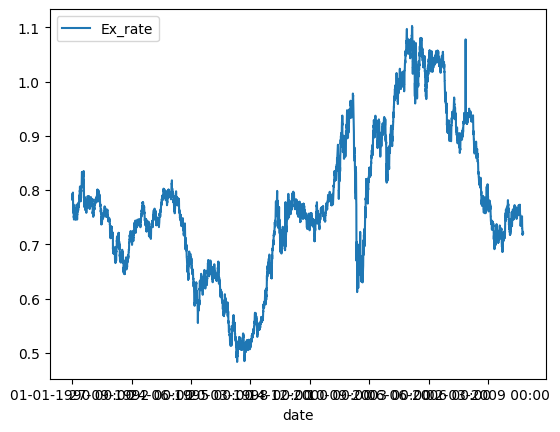

In [7]:
df.plot()

In [8]:
print(df.isnull().sum())

Ex_rate    0
dtype: int64


In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
# ADF Test for Stationarity (helps determine 'd')
adf_result = adfuller(df['Ex_rate'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -1.6649941807381528
p-value: 0.4492327353597901


In [18]:
adfuller(df['Ex_rate'])[1] # returns p value at index 1

0.4492327353597901

In [22]:
#series is non-stationary take first difference
df_diff = df['Ex_rate'].diff().dropna()

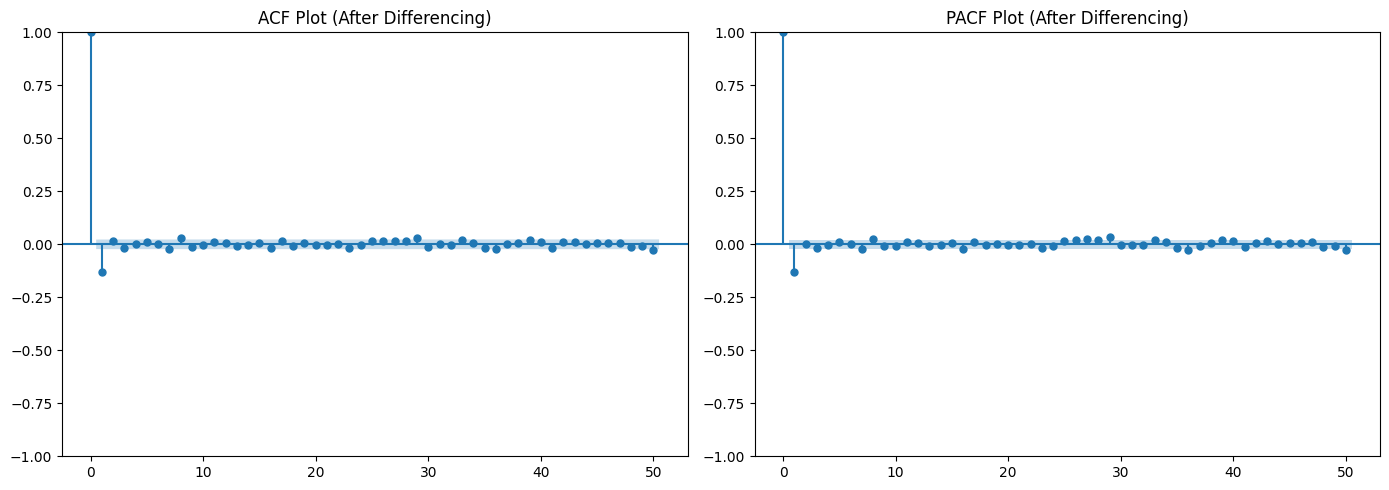

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df_diff, ax=axes[0], lags=50)
plot_pacf(df_diff, ax=axes[1], lags=50)
axes[0].set_title("ACF Plot (After Differencing)")
axes[1].set_title("PACF Plot (After Differencing)")
plt.tight_layout()
plt.show()

# Model

In [26]:
from statsmodels.tsa.arima.model import ARIMA

In [28]:
# Fit ARIMA model with example parameters (p=1, d=1, q=1)
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
model_fit = model.fit()

C:\Users\DELL\anaconda3\envs\DS_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\envs\DS_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\envs\DS_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


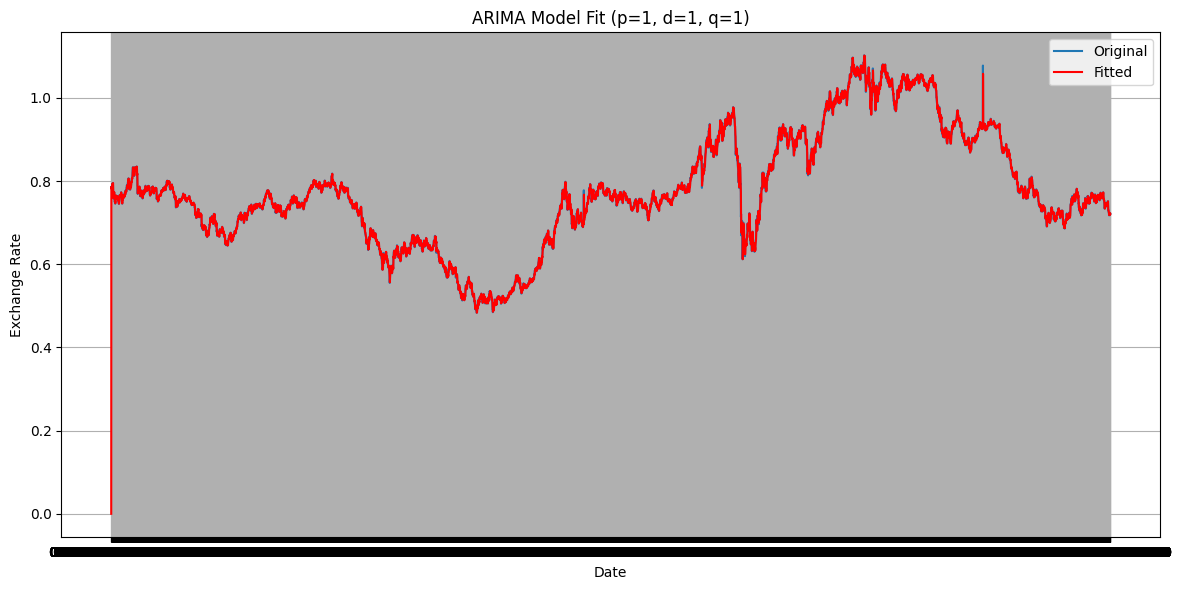

In [30]:
# Plot actual vs fitted values
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Original')
plt.plot(model_fit.fittedvalues, label='Fitted', color='red')
plt.title('ARIMA Model Fit (p=1, d=1, q=1)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Residuals Over Time')

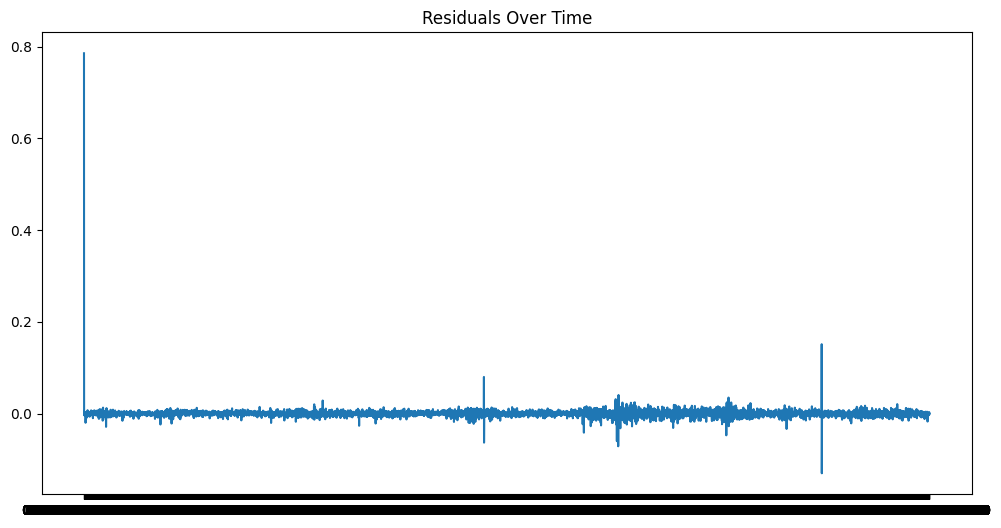

In [41]:
residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title("Residuals Over Time")

In [35]:
import seaborn as sns
import scipy.stats as stats

Text(0.5, 1.0, 'Histogram of Residuals')

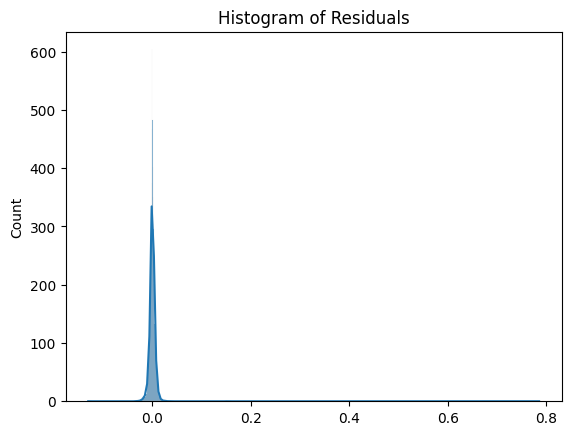

In [40]:
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")

Text(0.5, 1.0, 'Q-Q Plot')

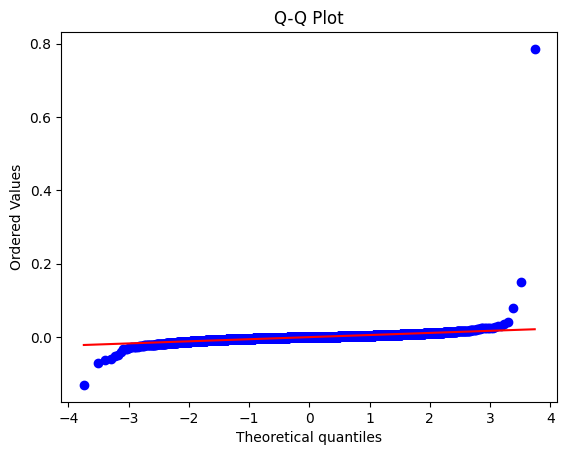

In [39]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")

In [43]:
residuals.sort_values(ascending=False).head()

date
01-01-1990 00:00    0.785500
16-02-2008 00:00    0.151226
30-10-1999 00:00    0.079807
19-02-2003 00:00    0.040463
02-11-2005 00:00    0.034881
dtype: float64

# Spliting into train and test

In [48]:
train = df.iloc[:- 50]  # last 50 for test
test = df.iloc[- 50:]

In [64]:
# 2. Fit ARIMA model on training data
model = ARIMA(train['Ex_rate'], order=(1,1,1))  # use your selected (p,d,q)
model_fit = model.fit()

In [65]:
# 3. Forecast next 50 steps
forecast = model_fit.forecast(steps=50)

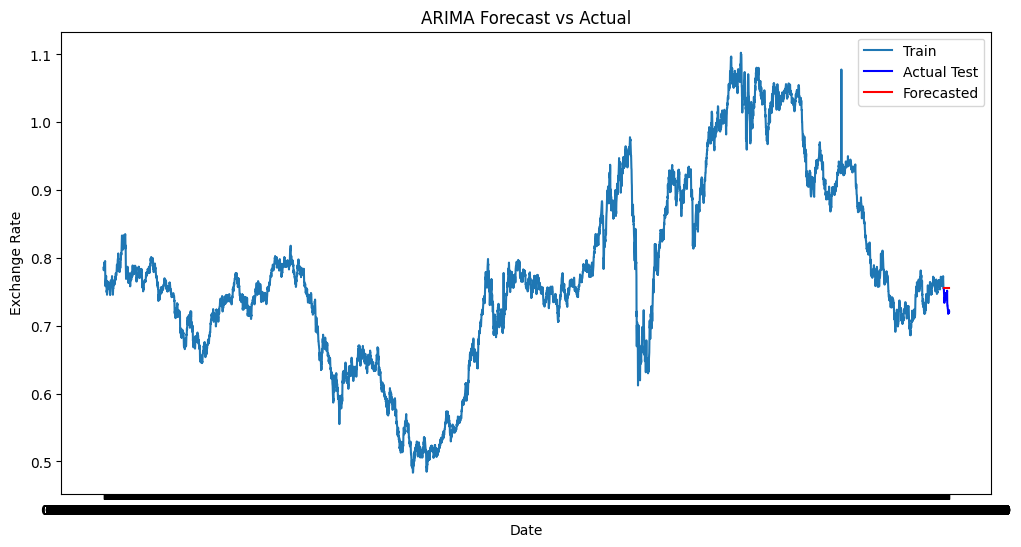

In [66]:
# 4. Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Ex_rate'], label='Train')
plt.plot(test.index, test['Ex_rate'], label='Actual Test', color='blue')
plt.plot(test.index, forecast, label='Forecasted', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [68]:
rmse = np.sqrt(mean_squared_error(test['Ex_rate'], forecast))
mae = mean_absolute_error(test['Ex_rate'], forecast)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.0217
MAE: 0.0184


### Exchange rate data seems to exhibit trend but no clear seasonality, so we go with Holt’s Linear Trend Model.

In [69]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [70]:
# Fit Holt's Linear Trend model on training data
holt_model = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal=None).fit()

In [71]:
# Forecast for the length of test set
holt_forecast = holt_model.forecast(steps=len(test))

In [73]:
holt_forecast

7538    0.755399
7539    0.755395
7540    0.755391
7541    0.755388
7542    0.755384
7543    0.755380
7544    0.755376
7545    0.755372
7546    0.755368
7547    0.755364
7548    0.755360
7549    0.755356
7550    0.755352
7551    0.755348
7552    0.755344
7553    0.755340
7554    0.755337
7555    0.755333
7556    0.755329
7557    0.755325
7558    0.755321
7559    0.755317
7560    0.755313
7561    0.755309
7562    0.755305
7563    0.755301
7564    0.755297
7565    0.755293
7566    0.755289
7567    0.755286
7568    0.755282
7569    0.755278
7570    0.755274
7571    0.755270
7572    0.755266
7573    0.755262
7574    0.755258
7575    0.755254
7576    0.755250
7577    0.755246
7578    0.755242
7579    0.755238
7580    0.755235
7581    0.755231
7582    0.755227
7583    0.755223
7584    0.755219
7585    0.755215
7586    0.755211
7587    0.755207
dtype: float64

In [74]:
rmse = np.sqrt(mean_squared_error(test['Ex_rate'], holt_forecast))
mae = mean_absolute_error(test['Ex_rate'], holt_forecast)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.0216
MAE: 0.0184


# Hyperparameter Tuning

In [76]:
# Best model placeholder
best_model = None
best_aic = np.inf
best_alpha = None
best_beta = None

In [77]:
# Try alpha and beta values between 0.1 to 1.0
alpha_values = np.arange(0.1, 1.1, 0.1)
beta_values = np.arange(0.1, 1.1, 0.1)

In [78]:
for alpha in alpha_values:
    for beta in beta_values:
        try:
            model = ExponentialSmoothing(
                train['Ex_rate'],
                trend='add',
                seasonal=None
            ).fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
            
            if model.aic < best_aic:
                best_model = model
                best_aic = model.aic
                best_alpha = alpha
                best_beta = beta
        except:
            continue

In [79]:
print(f"Best AIC: {best_aic}")
print(f"Best alpha (smoothing_level): {best_alpha}")
print(f"Best beta (smoothing_slope): {best_beta}")


Best AIC: -76730.99653096552
Best alpha (smoothing_level): 0.8
Best beta (smoothing_slope): 0.1


In [80]:
best_model

# Forecasting using best parameters

In [84]:
# Forecast using best model
best_forecast = best_model.forecast(steps=len(test))

In [85]:
rmse = np.sqrt(mean_squared_error(test['Ex_rate'], best_forecast))
mae = mean_absolute_error(test['Ex_rate'], best_forecast)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.0097
MAE: 0.0077


# Error metrics for comparing model perfromance 

In [86]:
# Define MAPE manually
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [89]:
mae_arima = mean_absolute_error(test['Ex_rate'], forecast)
rmse_arima = np.sqrt(mean_squared_error(test['Ex_rate'], forecast))

print("ARIMA Forecast Evaluation:")
print(f"MAE: {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")

ARIMA Forecast Evaluation:
MAE: 0.0184
RMSE: 0.0217


In [91]:
mae_best_model = mean_absolute_error(test['Ex_rate'], best_forecast)
rmse_best_model = np.sqrt(mean_squared_error(test['Ex_rate'], best_forecast))

print("\nHolt's Forecast Evaluation after hyperparamter tuning:")
print(f"MAE: {mae_best_model:.4f}")
print(f"RMSE: {rmse_best_model:.4f}")


Holt's Forecast Evaluation after hyperparamter tuning:
MAE: 0.0077
RMSE: 0.0097


### Model Comparison:
#### In this study, three different forecasting models were developed and compared: a basic ARIMA model, Holt’s Linear Trend model, and Holt’s model with hyperparameter tuning. Both the ARIMA model and the untuned Holt’s model yielded identical performance with a MAE of 0.0184 and RMSE of 0.0217, indicating moderate forecasting accuracy. 
##### The ARIMA model proved effective in modeling linear relationships with autoregressive and moving average components, but required the series to be stationary and involved more complex parameter tuning.
##### On the other hand, Holt’s Linear model offered a simpler and more interpretable approach by directly capturing trend without requiring differencing or stationarity transformation.
##### However, both of these models fell short when compared to the tuned Holt’s model. After optimizing the smoothing parameters, the performance of Holt’s model significantly improved, reducing the MAE to 0.0077 and RMSE to 0.0097. This substantial drop in forecasting error highlights the importance of parameter tuning in improving model performance, especially in time series where trends are present but seasonality is minimal or absent.

### Conclusion:
Based on the evaluation metrics:

The hyperparameter-tuned Holt’s Linear model delivered the best performance, with a 60%+ reduction in error (both MAE and RMSE) compared to the standard ARIMA and Holt models.

This suggests that trend-based exponential smoothing models, when finely tuned, can effectively capture the behavior of the exchange rate in this dataset.

ARIMA and untuned Holt’s model performed equally, but were inferior to the tuned version.